In [169]:

# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import itertools
from torch import nn
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation')
sys.path.append(parent_dir)

from toy_models.tms import AutoencoderSymmetric, GenerateTMSData, GenerateTMSDataParallel, AutoencoderParallel  # Import your model
from evaluation.networks import DrawNeuralNetwork
from eigenmodel.eigenmodel import EigenModel
from utils.loss import MSELoss
from utils.uniform_models import ZeroOutput
from typing import List
import itertools
from torch import Tensor
n_choose_k_combos = list(itertools.combinations(range(3), 2))

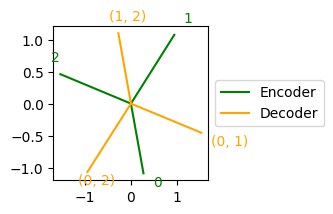

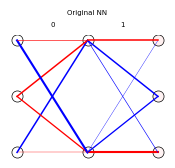

array([[ 0.90633786,  0.911827  , -1.2723442 ],
       [ 0.92619497, -2.024409  ,  0.93043107],
       [-2.513057  ,  0.9315232 ,  0.9172652 ]], dtype=float32)

In [148]:

# Load TMS model
tms_combo_path = "../outputs/toy_models/tms_combo.pt"


tms_combo_model = torch.load(tms_combo_path)['model']

# Plot TMS representations.
# Get all N choose k combinations of a number list
n_choose_k_combos = list(itertools.combinations(range(3), 2))


en = copy.deepcopy(tms_combo_model.W_in).detach().cpu().numpy().transpose()
plt.figure(figsize=(2,2))
for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'g-')
  plt.text(.2*en[0,i]/abs(en[0,i])+en[0,i], .2*en[1,i]/abs(en[1,i])+en[1,i], str(i), fontsize=10, color='green')
#plt.show()

#plt.figure(figsize=(2,2))
# Plot TMS representations.
dec = copy.deepcopy(tms_combo_model.W_out).detach().cpu().numpy()
for i in range(dec.shape[1]):
  plt.plot([0, dec[0,i]], [0,dec[1,i]], '-', color='orange')
  # Label the vectors at the end
  plt.text(.2*dec[0,i]/abs(dec[0,i])+dec[0,i], .2*dec[1,i]/abs(dec[1,i])+dec[1,i], n_choose_k_combos[i], fontsize=10, color='orange')
  

# Add blue and red indictors to legend
plt.plot([0,0], [0,0], 'g-', label='Encoder')
plt.plot([0,0], [0,0], '-', color='orange', label='Decoder')

# Move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
model_params = dict(tms_combo_model.named_parameters())
weights = {k:v for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v.transpose(0,1) for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")

en.transpose() @ dec

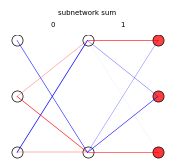

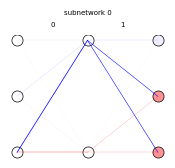

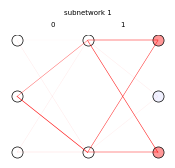

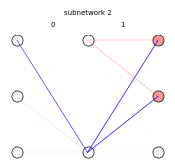

In [162]:
eigenmodel_path = "../outputs/eigenmodels/tms_combo.pt"


checkpoint = torch.load(eigenmodel_path)
eigenmodel = EigenModel(tms_combo_model, ZeroOutput, MSELoss(), 15, 1)
eigenmodel = checkpoint['model']

model_params = eigenmodel.reconstruct_network()
weights = {k:v.transpose(0,1) for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}


figs = DrawNeuralNetwork(weights, biases, title='subnetwork sum')
figs = []

for i, network in enumerate(eigenmodel.construct_subnetworks()):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    
    figs.append(DrawNeuralNetwork(weights, biases, title=f'subnetwork {i}'))